## Project 1
### PGA Tour Golf Stats

In [51]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import os
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import linregress

## Data Import and Cleaning

In [2]:
# Declare input file paths and file names
pga_data_hist_file = os.path.join(".", "input_data", "PGA_Data_Historical.csv")
player_exp_file = os.path.join(".", "input_data", "Scoring_Average_1980_2019.csv")


In [3]:
# Load main player and stat data into dataframe
all_pga_data_df = pd.read_csv(pga_data_hist_file)

# Load player experience lookup table
player_exp_df = pd.read_csv(player_exp_file)

In [4]:
# Data cleaning on the player experience input file CSV

# Get count of years each player has been on tour
# Only count years prior to 2019
player_exp_df["Year"] = pd.DatetimeIndex(player_exp_df["DATE"]).year
player_exp_df = player_exp_df.loc[player_exp_df["Year"] < 2019,:]
player_exp_df.drop(["DATE", "TOURNAMENT", "Scoring Average - (AVG)", "Scoring Average - (RANK THIS WEEK)"], axis=1, inplace=True)
player_exp_df.drop_duplicates(inplace=True)
player_exp_df["Years_on_Tour"] = player_exp_df.groupby("PLAYER_NAME").transform("count")
player_exp_df.drop("Year", axis=1, inplace=True)
player_exp_df.drop_duplicates(inplace=True)

# Merge player experience into main dataframe
all_pga_data_df = all_pga_data_df.merge(player_exp_df, how='left', left_on="Player Name", right_on="PLAYER_NAME")
all_pga_data_df.drop("PLAYER_NAME", axis=1, inplace=True)

In [5]:
# Create a filtered dataframe with only the stats we are interested in

# Define list of stats to keep
keep_variable_stats =  ["Season",
                        "Driving Distance - (AVG.)",
                        "Smash Factor - (AVG.)",
                        "Short Game Rating - (RATING)",
                        "Proximity to Hole (ARG) - (AVG DTP)",
                        "Putting Average - (AVG)",
                        "Total Money (Official and Unofficial) - (MONEY)"]

# Define count of stats we are keeping for each player
desired_var_stats_cnt = len(keep_variable_stats)

# Create filtered dataframe
temp_filtered_stats = all_pga_data_df.copy()
temp_filtered_stats = temp_filtered_stats.loc[temp_filtered_stats["Variable"].isin(keep_variable_stats),:]

# Drop the Statistic column, and just keep the Variable column
temp_filtered_stats.drop(["Statistic"], axis=1, inplace=True)

# Rename Variable column
temp_filtered_stats.rename(columns={"Variable" : "Statistic"}, inplace=True)

temp_filtered_stats.head()

,Player Name,Season,Statistic,Value,Years_on_Tour
192,Robert Garrigus,2010,Driving Distance - (AVG.),315.5,13.0
193,Bubba Watson,2010,Driving Distance - (AVG.),309.8,13.0
194,Dustin Johnson,2010,Driving Distance - (AVG.),308.5,11.0
195,Brett Wetterich,2010,Driving Distance - (AVG.),307.3,9.0
196,J.B. Holmes,2010,Driving Distance - (AVG.),307.2,13.0


In [6]:
# Create new dataframe to move our statistics from row values to columns

# Define columns of the new dataframe
desired_columns_lst = ["Player Name",
                       "Season",
                       "Driving Distance - (AVG.)", 
                       "Smash Factor - (AVG.)",
                       "Short Game Rating - (RATING)",
                       "Proximity to Hole (ARG) - (AVG DTP)",
                       "Putting Average - (AVG)",
                       "Total Money (Official and Unofficial) - (MONEY)",
                       "Years_on_Tour"]
                
cln_all_pga_data_df = pd.DataFrame(columns = desired_columns_lst)


for index, rows in temp_filtered_stats.iterrows():  
    # Search if name and season is in the dataframe, if not add
    search = cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"])]
    if len(search) == 0:
        # Name and season not found.  Insert name, season, and statistic
        data = [{"Player Name" : rows["Player Name"],
                 "Season" : rows["Season"],
                 rows["Statistic"] : rows["Value"],
                 "Years_on_Tour" : rows["Years_on_Tour"]}]            
        cln_all_pga_data_df = cln_all_pga_data_df.append(data, ignore_index=True, sort=False)
    else:
        # Name and season found.  Just add the statistic
        cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"]), rows["Statistic"]] = rows["Value"]    

In [7]:
# Data cleaning - Drop rows with NaN values
cln_all_pga_data_df.dropna(axis=0, how='any', inplace=True)


# Data cleaning - Convert the Proximity to Hole (ARG) - (AVG DTP) to inches
# Define function to perform conversion
def conv_dtp_to_inches(input_dtp):
    split_str = input_dtp.split("' ")
    feet = float(split_str[0])
    inches = float(split_str[1].replace("\"",""))
    return (12 * feet) + inches

cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"] = cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP)"].apply(lambda x:conv_dtp_to_inches(x))

# Drop old Proximity to Hole (ARG) - (AVG DTP) column
cln_all_pga_data_df.drop("Proximity to Hole (ARG) - (AVG DTP)", axis=1, inplace=True)


# Data cleaning - Remove dollar sign and commas from earnings column

cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace('$','')
cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace(',','')


In [8]:
# Rearrange columns
column_order = ["Player Name",
                "Season",
                "Driving Distance - (AVG.)",
                "Smash Factor - (AVG.)",
                "Short Game Rating - (RATING)",
                "Proximity to Hole (ARG) - (AVG DTP) (IN)",
                "Putting Average - (AVG)",
                "Total Money (Official and Unofficial) - (MONEY)",
                "Years_on_Tour"]

cln_all_pga_data_df = cln_all_pga_data_df.reindex(columns=column_order)


In [9]:
cln_all_pga_data_df.head()

,Player Name,Season,Driving Distance - (AVG.),Smash Factor - (AVG.),Short Game Rating - (RATING),Proximity to Hole (ARG) - (AVG DTP) (IN),Putting Average - (AVG),Total Money (Official and Unofficial) - (MONEY),Years_on_Tour
0,Robert Garrigus,2010,315.5,1.475,5.5,103.0,1.786,1583275,13.0
1,Bubba Watson,2010,309.8,1.477,5.6,97.0,1.763,3655665,13.0
2,Dustin Johnson,2010,308.5,1.479,5.8,94.0,1.767,5280289,11.0
3,Brett Wetterich,2010,307.3,1.477,6.0,97.0,1.801,510672,9.0
4,J.B. Holmes,2010,307.2,1.480,6.2,84.0,1.770,2746248,13.0


In [10]:
# Convert stat columns to appropriate datatypes

# Define a conversion dictionary
conversion_dict = {"Season" : "int64",
                   "Driving Distance - (AVG.)" : "float64",
                   "Smash Factor - (AVG.)" : "float64",
                   "Short Game Rating - (RATING)" : "float64",
                   "Proximity to Hole (ARG) - (AVG DTP) (IN)" : "float64",
                   "Putting Average - (AVG)" : "float64",
                   "Total Money (Official and Unofficial) - (MONEY)" : "float64",
                   "Years_on_Tour" : "int64"                  
                 }

# Convert column datatypes, ignore errors and keep any NaNs if they exist
cln_all_pga_data_df = cln_all_pga_data_df.astype(conversion_dict, errors="ignore")

cln_all_pga_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 3488
Data columns (total 9 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Player Name                                      1654 non-null   object 
 1   Season                                           1654 non-null   int64  
 2   Driving Distance - (AVG.)                        1654 non-null   float64
 3   Smash Factor - (AVG.)                            1654 non-null   float64
 4   Short Game Rating - (RATING)                     1654 non-null   float64
 5   Proximity to Hole (ARG) - (AVG DTP) (IN)         1654 non-null   float64
 6   Putting Average - (AVG)                          1654 non-null   float64
 7   Total Money (Official and Unofficial) - (MONEY)  1654 non-null   float64
 8   Years_on_Tour                                    1654 non-null   int64  
dtypes: float64(6), int64(2), object

In [11]:
# Output to CSV or Read from CSV using this cell

#cln_all_pga_data_df.to_csv("output_data/cln_all_pga_data_df.csv", index=False)

## Total Column, Row, and Player Counts

In [11]:
# Number of Rows
print(f"There are {cln_all_pga_data_df.shape[0]} rows and {cln_all_pga_data_df.shape[1]} columns in our dataset.")

There are 1654 rows and 9 columns in our dataset.


In [12]:
# Number of Players
nbr_total_players = len(cln_all_pga_data_df["Player Name"].unique())
print(f"There are {nbr_total_players} unique players in our dataset.")

There are 430 unique players in our dataset.


In [14]:
# Number of Players Per Season
player_cnt_by_season = cln_all_pga_data_df.copy()
player_cnt_by_season = player_cnt_by_season[["Player Name", "Season"]].drop_duplicates().groupby("Season").count().rename(columns={"Player Name" : "Player Count"})
player_cnt_by_season

,Player Count
Season,
2010,190
2011,184
2012,190
2013,178
2014,174
2015,180
2016,182
2017,185
2018,191


## Create Statistical Summary Tables

In [15]:
# DEFINE FUNCTION TO CALCULATE SUMMARY STATS 
def calculate_summ_stats(var_of_interest):
    for season in season_lst:
        driv_avg_data = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"] == season, var_of_interest]
        mean_lst.append([season, np.mean(driv_avg_data)])
        median_lst.append([season, np.median(driv_avg_data)])
        variance_lst.append([season, np.var(driv_avg_data)])
        std_dev_lst.append([season, np.std(driv_avg_data)])
        SEM_lst.append([season, st.sem(driv_avg_data)])
        k2, p = st.normaltest(driv_avg_data)
        normal_p_lst.append([season, p])
        

In [16]:
# CREATE STAT SUMMARY TABLE #1 - Driving Distance - (AVG.)

var_of_interest = "Driving Distance - (AVG.)"
season_lst = cln_all_pga_data_df["Season"].unique()
mean_lst = []
median_lst = []
variance_lst = []
std_dev_lst = []
SEM_lst = []
normal_p_lst = []

calculate_summ_stats(var_of_interest)

# Convert lists to dataframes.  We will later combine these together
mean_df = pd.DataFrame(mean_lst)
mean_df = mean_df.rename(columns={0:"Season", 1:"Mean Driving Distance (AVG)"})
median_df = pd.DataFrame(median_lst)
median_df = median_df.rename(columns={0:"Season", 1:"Median Driving Distance (AVG)"})
variance_df = pd.DataFrame(variance_lst)
variance_df = variance_df.rename(columns={0:"Season", 1:"Variance Driving Distance (AVG)"})
std_dev_df = pd.DataFrame(std_dev_lst)
std_dev_df = std_dev_df.rename(columns={0:"Season", 1:"Std Dev Driving Distance (AVG)"})
SEM_df = pd.DataFrame(SEM_lst)
SEM_df = SEM_df.rename(columns={0:"Season", 1:"SEM Driving Distance (AVG)"})
normal_p_df = pd.DataFrame(normal_p_lst)
normal_p_df = normal_p_df.rename(columns={0:"Season", 1:"Normality (p) Driving Distance (AVG)"})

# Create combined dataframe of summary stats
driv_stat_summ_df = mean_df.merge(median_df, on="Season", how='left')
driv_stat_summ_df = driv_stat_summ_df.merge(variance_df, on="Season", how='left')
driv_stat_summ_df = driv_stat_summ_df.merge(std_dev_df, on="Season", how='left')
driv_stat_summ_df = driv_stat_summ_df.merge(SEM_df, on="Season", how='left')
driv_stat_summ_df = driv_stat_summ_df.merge(normal_p_df, on="Season", how='left')
driv_stat_summ_df.set_index("Season", inplace=True)

driv_stat_summ_df

,Mean Driving Distance (AVG),Median Driving Distance (AVG),Variance Driving Distance (AVG),Std Dev Driving Distance (AVG),SEM Driving Distance (AVG),Normality (p) Driving Distance (AVG)
Season,,,,,,
2010,287.391579,287.75,66.131298,8.132115,0.591524,0.064939
2011,291.047283,291.05,69.342927,8.327240,0.615567,0.075794
2012,290.003158,289.50,69.784832,8.353732,0.607645,0.093977
2013,287.878652,288.10,64.315387,8.019687,0.602797,0.039218
2014,289.907471,289.70,75.076898,8.664693,0.658764,0.506604
2015,290.258889,289.65,84.069754,9.168956,0.685320,0.181522
2016,290.878022,289.80,75.530286,8.690816,0.645983,0.490563
2017,292.691892,292.50,87.295556,9.343209,0.688791,0.393433
2018,296.719372,296.10,65.959258,8.121531,0.589198,0.166828


In [17]:
# CREATE STAT SUMMARY TABLE #2 - Smash Factor - (AVG.)

var_of_interest = "Smash Factor - (AVG.)"
season_lst = cln_all_pga_data_df["Season"].unique()
mean_lst = []
median_lst = []
variance_lst = []
std_dev_lst = []
SEM_lst = []
normal_p_lst = []

calculate_summ_stats(var_of_interest)

# Convert lists to dataframes.  We will later combine these together
mean_df = pd.DataFrame(mean_lst)
mean_df = mean_df.rename(columns={0:"Season", 1:"Mean Smash Factor (AVG)"})
median_df = pd.DataFrame(median_lst)
median_df = median_df.rename(columns={0:"Season", 1:"Median Smash Factor (AVG)"})
variance_df = pd.DataFrame(variance_lst)
variance_df = variance_df.rename(columns={0:"Season", 1:"Variance Smash Factor (AVG)"})
std_dev_df = pd.DataFrame(std_dev_lst)
std_dev_df = std_dev_df.rename(columns={0:"Season", 1:"Std Dev Smash Factor (AVG)"})
SEM_df = pd.DataFrame(SEM_lst)
SEM_df = SEM_df.rename(columns={0:"Season", 1:"SEM Smash Factor (AVG)"})
normal_p_df = pd.DataFrame(normal_p_lst)
normal_p_df = normal_p_df.rename(columns={0:"Season", 1:"Normality (p) Smash Factor (AVG)"})

# Create combined dataframe of summary stats
smash_stat_summ_df = mean_df.merge(median_df, on="Season", how='left')
smash_stat_summ_df = smash_stat_summ_df.merge(variance_df, on="Season", how='left')
smash_stat_summ_df = smash_stat_summ_df.merge(std_dev_df, on="Season", how='left')
smash_stat_summ_df = smash_stat_summ_df.merge(SEM_df, on="Season", how='left')
smash_stat_summ_df = smash_stat_summ_df.merge(normal_p_df, on="Season", how='left')
smash_stat_summ_df.set_index("Season", inplace=True)

smash_stat_summ_df

,Mean Smash Factor (AVG),Median Smash Factor (AVG),Variance Smash Factor (AVG),Std Dev Smash Factor (AVG),SEM Smash Factor (AVG),Normality (p) Smash Factor (AVG)
Season,,,,,,
2010,1.474942,1.477,0.000034,0.005805,0.000422,4.621346e-23
2011,1.478457,1.481,0.000042,0.006487,0.000480,3.398106e-12
2012,1.479189,1.482,0.000039,0.006274,0.000456,1.691666e-12
2013,1.479303,1.482,0.000044,0.006642,0.000499,5.831661e-22
2014,1.479080,1.482,0.000047,0.006859,0.000521,4.538144e-17
2015,1.480839,1.484,0.000147,0.012107,0.000905,1.842809e-05
2016,1.485264,1.486,0.000275,0.016570,0.001232,3.836335e-03
2017,1.483335,1.486,0.000186,0.013627,0.001005,9.223675e-05
2018,1.487770,1.490,0.000203,0.014243,0.001033,1.806057e-15


In [18]:
# CREATE STAT SUMMARY TABLE #3 - Short Game Rating - (RATING)

var_of_interest = "Short Game Rating - (RATING)"
season_lst = cln_all_pga_data_df["Season"].unique()
mean_lst = []
median_lst = []
variance_lst = []
std_dev_lst = []
SEM_lst = []
normal_p_lst = []

calculate_summ_stats(var_of_interest)

# Convert lists to dataframes.  We will later combine these together
mean_df = pd.DataFrame(mean_lst)
mean_df = mean_df.rename(columns={0:"Season", 1:"Mean Short Game Rating"})
median_df = pd.DataFrame(median_lst)
median_df = median_df.rename(columns={0:"Season", 1:"Median Short Game Rating"})
variance_df = pd.DataFrame(variance_lst)
variance_df = variance_df.rename(columns={0:"Season", 1:"Variance Short Game Rating"})
std_dev_df = pd.DataFrame(std_dev_lst)
std_dev_df = std_dev_df.rename(columns={0:"Season", 1:"Std Dev Short Game Rating"})
SEM_df = pd.DataFrame(SEM_lst)
SEM_df = SEM_df.rename(columns={0:"Season", 1:"SEM Short Game Rating"})
normal_p_df = pd.DataFrame(normal_p_lst)
normal_p_df = normal_p_df.rename(columns={0:"Season", 1:"Normality (p) Short Game Rating"})

# Create combined dataframe of summary stats
sht_gm_rat_summ_df = mean_df.merge(median_df, on="Season", how='left')
sht_gm_rat_summ_df = sht_gm_rat_summ_df.merge(variance_df, on="Season", how='left')
sht_gm_rat_summ_df = sht_gm_rat_summ_df.merge(std_dev_df, on="Season", how='left')
sht_gm_rat_summ_df = sht_gm_rat_summ_df.merge(SEM_df, on="Season", how='left')
sht_gm_rat_summ_df = sht_gm_rat_summ_df.merge(normal_p_df, on="Season", how='left')
sht_gm_rat_summ_df.set_index("Season", inplace=True)

sht_gm_rat_summ_df

,Mean Short Game Rating,Median Short Game Rating,Variance Short Game Rating,Std Dev Short Game Rating,SEM Short Game Rating,Normality (p) Short Game Rating
Season,,,,,,
2010,6.313158,6.35,0.236616,0.486432,0.035383,0.002933
2011,6.288587,6.30,0.244381,0.494349,0.036543,0.532774
2012,6.240000,6.30,0.263558,0.513379,0.037343,0.073532
2013,6.286517,6.30,0.251728,0.501725,0.037712,0.017887
2014,6.294253,6.30,0.235714,0.485504,0.036912,0.026615
2015,6.294444,6.30,0.242302,0.492242,0.036792,0.616054
2016,6.279121,6.30,0.285059,0.533909,0.039685,0.002451
2017,6.285405,6.30,0.213571,0.462137,0.034069,0.522961
2018,6.279581,6.20,0.287175,0.535887,0.038877,0.500227


In [19]:
# CREATE STAT SUMMARY TABLE #4 - Proximity to Hole (ARG) - (AVG DTP) (IN)

var_of_interest = "Proximity to Hole (ARG) - (AVG DTP) (IN)"
season_lst = cln_all_pga_data_df["Season"].unique()
mean_lst = []
median_lst = []
variance_lst = []
std_dev_lst = []
SEM_lst = []
normal_p_lst = []

calculate_summ_stats(var_of_interest)

# Convert lists to dataframes.  We will later combine these together
mean_df = pd.DataFrame(mean_lst)
mean_df = mean_df.rename(columns={0:"Season", 1:"Mean Proximity ARG (IN)"})
median_df = pd.DataFrame(median_lst)
median_df = median_df.rename(columns={0:"Season", 1:"Median Proximity ARG (IN)"})
variance_df = pd.DataFrame(variance_lst)
variance_df = variance_df.rename(columns={0:"Season", 1:"Variance Proximity ARG (IN)"})
std_dev_df = pd.DataFrame(std_dev_lst)
std_dev_df = std_dev_df.rename(columns={0:"Season", 1:"Std Dev Proximity ARG (IN)"})
SEM_df = pd.DataFrame(SEM_lst)
SEM_df = SEM_df.rename(columns={0:"Season", 1:"SEM Proximity ARG (IN)"})
normal_p_df = pd.DataFrame(normal_p_lst)
normal_p_df = normal_p_df.rename(columns={0:"Season", 1:"Normality (p) Proximity ARG (IN)"})

# Create combined dataframe of summary stats
prox_arg_stat_summ_df = mean_df.merge(median_df, on="Season", how='left')
prox_arg_stat_summ_df = prox_arg_stat_summ_df.merge(variance_df, on="Season", how='left')
prox_arg_stat_summ_df = prox_arg_stat_summ_df.merge(std_dev_df, on="Season", how='left')
prox_arg_stat_summ_df = prox_arg_stat_summ_df.merge(SEM_df, on="Season", how='left')
prox_arg_stat_summ_df = prox_arg_stat_summ_df.merge(normal_p_df, on="Season", how='left')
prox_arg_stat_summ_df.set_index("Season", inplace=True)

prox_arg_stat_summ_df

,Mean Proximity ARG (IN),Median Proximity ARG (IN),Variance Proximity ARG (IN),Std Dev Proximity ARG (IN),SEM Proximity ARG (IN),Normality (p) Proximity ARG (IN)
Season,,,,,,
2010,88.268421,88.0,46.975319,6.853854,0.498545,0.888053
2011,88.657609,88.0,43.257768,6.577064,0.486191,0.088839
2012,89.652632,89.0,37.195125,6.098781,0.443621,0.171785
2013,84.910112,84.5,38.194167,6.180143,0.464528,0.518472
2014,87.459770,88.0,38.007002,6.164982,0.468715,0.324275
2015,87.661111,87.0,41.324043,6.428378,0.480480,0.435218
2016,87.961538,87.5,34.553466,5.878220,0.436925,0.424306
2017,88.340541,88.0,28.192140,5.309627,0.391431,0.714184
2018,90.335079,91.0,40.254215,6.344621,0.460287,0.748133


In [20]:
# CREATE STAT SUMMARY TABLE #5 - Putting Average - (AVG)

var_of_interest = "Putting Average - (AVG)"
season_lst = cln_all_pga_data_df["Season"].unique()
mean_lst = []
median_lst = []
variance_lst = []
std_dev_lst = []
SEM_lst = []
normal_p_lst = []

calculate_summ_stats(var_of_interest)

# Convert lists to dataframes.  We will later combine these together
mean_df = pd.DataFrame(mean_lst)
mean_df = mean_df.rename(columns={0:"Season", 1:"Mean Putting Average"})
median_df = pd.DataFrame(median_lst)
median_df = median_df.rename(columns={0:"Season", 1:"Median Putting Average"})
variance_df = pd.DataFrame(variance_lst)
variance_df = variance_df.rename(columns={0:"Season", 1:"Variance Putting Average"})
std_dev_df = pd.DataFrame(std_dev_lst)
std_dev_df = std_dev_df.rename(columns={0:"Season", 1:"Std Dev Putting Average"})
SEM_df = pd.DataFrame(SEM_lst)
SEM_df = SEM_df.rename(columns={0:"Season", 1:"SEM Putting Average"})
normal_p_df = pd.DataFrame(normal_p_lst)
normal_p_df = normal_p_df.rename(columns={0:"Season", 1:"Normality (p) Putting Average"})

# Create combined dataframe of summary stats
putt_avg_stat_summ_df = mean_df.merge(median_df, on="Season", how='left')
putt_avg_stat_summ_df = putt_avg_stat_summ_df.merge(variance_df, on="Season", how='left')
putt_avg_stat_summ_df = putt_avg_stat_summ_df.merge(std_dev_df, on="Season", how='left')
putt_avg_stat_summ_df = putt_avg_stat_summ_df.merge(SEM_df, on="Season", how='left')
putt_avg_stat_summ_df = putt_avg_stat_summ_df.merge(normal_p_df, on="Season", how='left')
putt_avg_stat_summ_df.set_index("Season", inplace=True)

putt_avg_stat_summ_df

,Mean Putting Average,Median Putting Average,Variance Putting Average,Std Dev Putting Average,SEM Putting Average,Normality (p) Putting Average
Season,,,,,,
2010,1.782753,1.7805,0.000669,0.025868,0.001882,0.155302
2011,1.780293,1.7805,0.000694,0.026335,0.001947,0.271190
2012,1.779863,1.7830,0.000541,0.023251,0.001691,0.574566
2013,1.781376,1.7815,0.000800,0.028289,0.002126,0.125408
2014,1.776345,1.7710,0.000724,0.026907,0.002046,0.056658
2015,1.770189,1.7700,0.000611,0.024713,0.001847,0.740211
2016,1.773214,1.7745,0.000518,0.022765,0.001692,0.221528
2017,1.773789,1.7740,0.000587,0.024230,0.001786,0.332234
2018,1.769838,1.7720,0.000539,0.023225,0.001685,0.169137


## Analyze Driving Distance Average

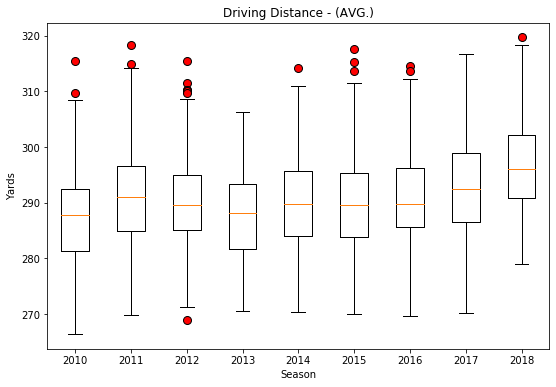

In [23]:
# BOXPLOT FOR AVERAGE DRIVING DISTANCE

var_of_interest = "Driving Distance - (AVG.)"

driv_dist_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,var_of_interest]
driv_dist_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,var_of_interest]
driv_dist_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,var_of_interest]
driv_dist_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,var_of_interest]
driv_dist_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,var_of_interest]
driv_dist_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,var_of_interest]
driv_dist_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,var_of_interest]
driv_dist_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,var_of_interest]
driv_dist_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,var_of_interest]

driv_data_boxplot_to_plot = [driv_dist_2010, driv_dist_2011, driv_dist_2012,
                             driv_dist_2013, driv_dist_2014, driv_dist_2015,
                             driv_dist_2016, driv_dist_2017, driv_dist_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(driv_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=8.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = var_of_interest,
       xlabel = "Season",
       ylabel = "Yards")
plt.show()

In [24]:
# DRIVING DISTANCE ONE-WAY ANOVA
# Our null hypothesis states that there are equal means in the populations from which the groups of data were sampled

print(st.f_oneway(driv_dist_2010, driv_dist_2011, driv_dist_2012,
                  driv_dist_2013, driv_dist_2014, driv_dist_2015,
                  driv_dist_2016, driv_dist_2017, driv_dist_2018))

print("P-value is < 0.05, therefore there are significant differences among the means")

F_onewayResult(statistic=19.425638151677187, pvalue=3.5480725334366345e-28)
P-value is < 0.05, therefore there are significant differences among the means


In [25]:
m_comp = pairwise_tukeyhsd(endog=cln_all_pga_data_df["Driving Distance - (AVG.)"], groups=cln_all_pga_data_df["Season"], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2010   2011   3.6557 0.0013  0.9037  6.4077   True
  2010   2012   2.6116 0.0739 -0.1182  5.3414  False
  2010   2013   0.4871    0.9 -2.2884  3.2625  False
  2010   2014   2.5159 0.1167  -0.276  5.3078  False
  2010   2015   2.8673 0.0356  0.0998  5.6348   True
  2010   2016   3.4864 0.0029  0.7268  6.2461   True
  2010   2017   5.3003  0.001  2.5521  8.0485   True
  2010   2018   9.3278  0.001  6.6015  12.054   True
  2011   2012  -1.0441    0.9 -3.7961  1.7079  False
  2011   2013  -3.1686 0.0132 -5.9659 -0.3714   True
  2011   2014  -1.1398    0.9 -3.9534  1.6737  False
  2011   2015  -0.7884    0.9 -3.5777  2.0009  False
  2011   2016  -0.1693    0.9 -2.9508  2.6123  False
  2011   2017   1.6446 0.6318 -1.1256  4.4148  False
  2011   2018   5.6721  0.001  2.9237  8.4205   True
  2012   2013  -2.1245 0.2972    -4.9  0.6509 

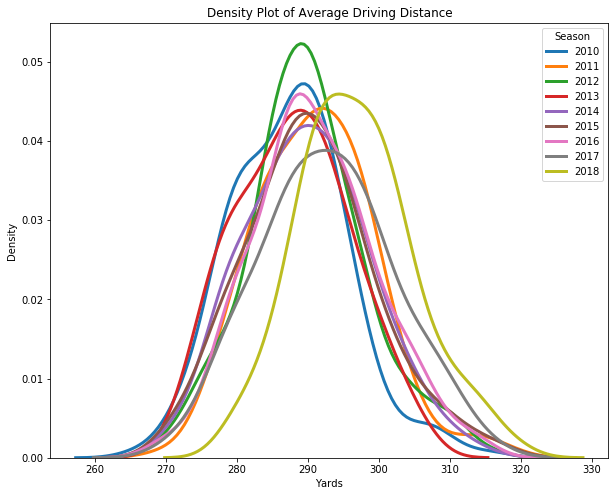

In [25]:
# DENSITY PLOT FOR AVERAGE DRIVING DISTANCE

var_of_interest = "Driving Distance - (AVG.)"
season_lst = cln_all_pga_data_df["Season"].unique()

fig = plt.figure(figsize=(10,8))

for season in season_lst:
    driv_dist_season = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==season, var_of_interest]
    
    sns.distplot(driv_dist_season, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = season)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Season');
plt.title("Density Plot of Average Driving Distance");
plt.xlabel("Yards");
plt.ylabel("Density");

In [66]:
# If we need these, this is how to split our dataframe into groups

# Create dataframes for groups of 3 years
cln_2010_2012_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010", "2011", "2012"]),:]
cln_2010_2012_df.reset_index(inplace=True)

cln_2010_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010"]),:]
cln_2010_df.reset_index(inplace=True)

cln_2013_2015_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2013", "2014", "2015"]),:]
cln_2013_2015_df.reset_index(inplace=True)

cln_2016_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2016", "2017", "2018"]),:]
cln_2016_2018_df.reset_index(inplace=True)

# Create dataframes for groups of 4 years
cln_2011_2014_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2011", "2012", "2013", "2014"]),:]
cln_2011_2014_df.reset_index(inplace=True)

cln_2015_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2015", "2016", "2017", "2018"]),:]
cln_2015_2018_df.reset_index(inplace=True)

cln_2010_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010"]),:]
cln_2010_df.reset_index(inplace=True)
cln_2011_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2011"]),:]
cln_2011_df.reset_index(inplace=True)
cln_2012_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2012"]),:]
cln_2012_df.reset_index(inplace=True)
cln_2013_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2013"]),:]
cln_2013_df.reset_index(inplace=True)
cln_2014_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2014"]),:]
cln_2014_df.reset_index(inplace=True)
cln_2015_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2015"]),:]
cln_2015_df.reset_index(inplace=True)
cln_2016_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2016"]),:]
cln_2016_df.reset_index(inplace=True)
cln_2017_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2017"]),:]
cln_2017_df.reset_index(inplace=True)
cln_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2018"]),:]
cln_2018_df.reset_index(inplace=True)

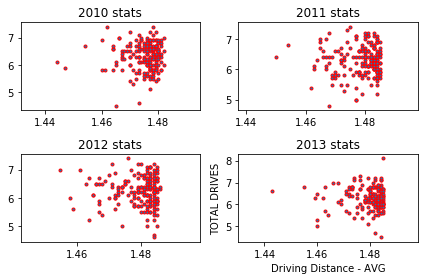

In [67]:

fig1, ((pl0t1, pl0t2), (pl0t3,pl0t4)) = plt.subplots(2, 2)
# fig.suptitle("something random", fontsize=16, fontweight="bold")


pl0t1.scatter(cln_2010_df.iloc[:,4], cln_2010_df.iloc[:,5], marker=".", edgecolors="red")
# pl0t1.plot(cln_2010_df.iloc[:,4], cln_2010_df.iloc[:,5], "b--", linewidth=1)
pl0t1.set_title("2010 stats")

pl0t2.scatter(cln_2011_df.iloc[:,4], cln_2011_df.iloc[:,5], marker=".", edgecolors="red")
pl0t2.set_title("2011 stats")

pl0t3.scatter(cln_2012_df.iloc[:,4], cln_2012_df.iloc[:,5], marker=".", edgecolors="red")
pl0t3.set_title("2012 stats")

pl0t4.scatter(cln_2013_df.iloc[:,4], cln_2013_df.iloc[:,5], marker=".", edgecolors="red")
pl0t4.set_title("2013 stats")
plt.xlabel("Driving Distance - AVG")
plt.ylabel("TOTAL DRIVES")

plt.tight_layout()

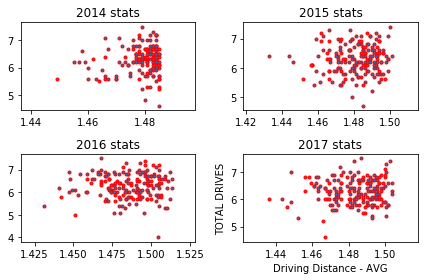

In [68]:
fig2, ((pl00t1, pl00t2), (pl00t3,pl00t4)) = plt.subplots(2, 2)
# fig.suptitle("something random", fontsize=16, fontweight="bold")


pl00t1.scatter(cln_2014_df.iloc[:,4], cln_2014_df.iloc[:,5], marker=".", edgecolors="red")
pl00t1.set_title("2014 stats")

pl00t2.scatter(cln_2015_df.iloc[:,4], cln_2015_df.iloc[:,5], marker=".", edgecolors="red")
pl00t2.set_title("2015 stats")

pl00t3.scatter(cln_2016_df.iloc[:,4], cln_2016_df.iloc[:,5], marker=".", edgecolors="red")
pl00t3.set_title("2016 stats")

pl00t4.scatter(cln_2017_df.iloc[:,4], cln_2017_df.iloc[:,5], marker=".", edgecolors="red")
pl00t4.set_title("2017 stats")
plt.xlabel("Driving Distance - AVG")
plt.ylabel("TOTAL DRIVES")

plt.tight_layout()

## Analyze Smash Factor

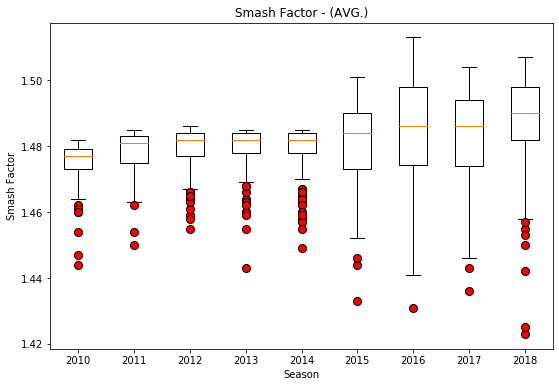

In [28]:
# BOXPLOT FOR SMASH FACTOR

var_of_interest = "Smash Factor - (AVG.)"

smash_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,var_of_interest]
smash_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,var_of_interest]
smash_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,var_of_interest]
smash_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,var_of_interest]
smash_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,var_of_interest]
smash_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,var_of_interest]
smash_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,var_of_interest]
smash_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,var_of_interest]
smash_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,var_of_interest]

smash_data_boxplot_to_plot = [smash_2010, smash_2011, smash_2012,
                             smash_2013, smash_2014, smash_2015,
                             smash_2016, smash_2017, smash_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(smash_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=8.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = var_of_interest,
       xlabel = "Season",
       ylabel = "Smash Factor")
plt.show()

In [29]:
# SMASH FACTOR ONE-WAY ANOVA
# Our null hypothesis states that there are equal means in the populations from which the groups of data were sampled

print(st.f_oneway(smash_2010, smash_2011, smash_2012,
                  smash_2013, smash_2014, smash_2015,
                  smash_2016, smash_2017, smash_2018))

print("P-value is < 0.05, therefore there are significant differences among the means")

F_onewayResult(statistic=25.279511118398805, pvalue=4.820995678579819e-37)
P-value is < 0.05, therefore there are significant differences among the means


In [30]:
m_comp = pairwise_tukeyhsd(endog=cln_all_pga_data_df["Smash Factor - (AVG.)"], groups=cln_all_pga_data_df["Season"], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2010   2011   0.0035 0.0394  0.0001 0.0069   True
  2010   2012   0.0042 0.0034  0.0008 0.0076   True
  2010   2013   0.0044  0.003  0.0009 0.0078   True
  2010   2014   0.0041 0.0069  0.0007 0.0076   True
  2010   2015   0.0059  0.001  0.0025 0.0093   True
  2010   2016   0.0103  0.001  0.0069 0.0138   True
  2010   2017   0.0084  0.001   0.005 0.0118   True
  2010   2018   0.0128  0.001  0.0094 0.0162   True
  2011   2012   0.0007    0.9 -0.0027 0.0042  False
  2011   2013   0.0008    0.9 -0.0026 0.0043  False
  2011   2014   0.0006    0.9 -0.0029 0.0041  False
  2011   2015   0.0024 0.4552 -0.0011 0.0059  False
  2011   2016   0.0068  0.001  0.0033 0.0103   True
  2011   2017   0.0049  0.001  0.0014 0.0083   True
  2011   2018   0.0093  0.001  0.0059 0.0127   True
  2012   2013   0.0001    0.9 -0.0033 0.0036  False
  2012   201

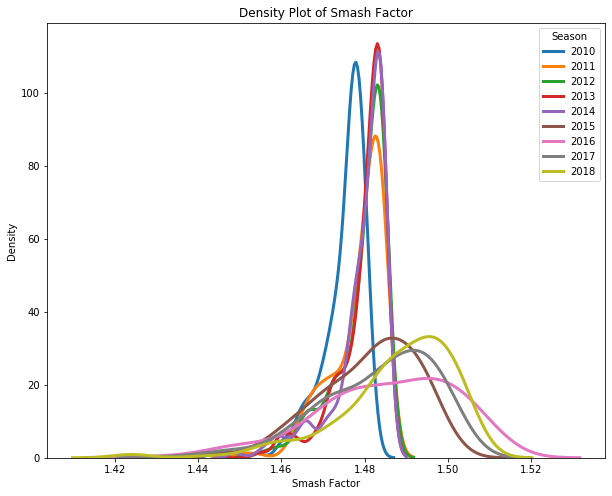

In [31]:
# DENSITY PLOT FOR SMASH FACTOR

var_of_interest = "Smash Factor - (AVG.)"
season_lst = cln_all_pga_data_df["Season"].unique()

fig = plt.figure(figsize=(10,8))

for season in season_lst:
    smash_season = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==season, var_of_interest]
    
    sns.distplot(smash_season, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = season)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Season');
plt.title("Density Plot of Smash Factor");
plt.xlabel("Smash Factor");
plt.ylabel("Density");

## Analyze Short Game Rating - (RATING)

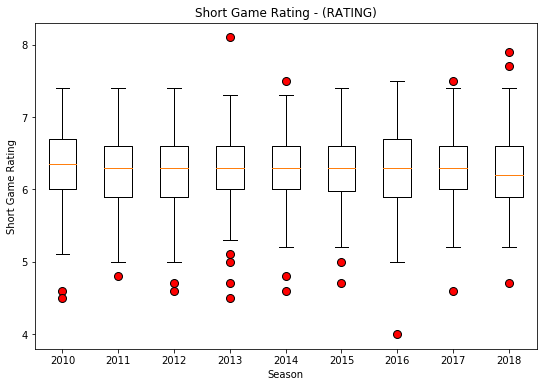

In [32]:
# BOXPLOT FOR SHORT GAME RATING

var_of_interest = "Short Game Rating - (RATING)"

short_gam_rat_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,var_of_interest]
short_gam_rat_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,var_of_interest]
short_gam_rat_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,var_of_interest]
short_gam_rat_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,var_of_interest]
short_gam_rat_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,var_of_interest]
short_gam_rat_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,var_of_interest]
short_gam_rat_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,var_of_interest]
short_gam_rat_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,var_of_interest]
short_gam_rat_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,var_of_interest]

short_gam_rat_data_boxplot_to_plot = [short_gam_rat_2010, short_gam_rat_2011, short_gam_rat_2012,
                             short_gam_rat_2013, short_gam_rat_2014, short_gam_rat_2015,
                             short_gam_rat_2016, short_gam_rat_2017, short_gam_rat_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(short_gam_rat_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=8.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = var_of_interest,
       xlabel = "Season",
       ylabel = "Short Game Rating")
plt.show()

In [33]:
# SHORT GAME RATING ONE-WAY ANOVA
# Our null hypothesis states that there are equal means in the populations from which the groups of data were sampled

print(st.f_oneway(short_gam_rat_2010, short_gam_rat_2011, short_gam_rat_2012,
                  short_gam_rat_2013, short_gam_rat_2014, short_gam_rat_2015,
                  short_gam_rat_2016, short_gam_rat_2017, short_gam_rat_2018))

print("P-value is >= 0.05, therefore there are NO significant differences among the means")

F_onewayResult(statistic=0.2871396338603883, pvalue=0.9704180428834331)
P-value is >= 0.05, therefore there are NO significant differences among the means


In [34]:
m_comp = pairwise_tukeyhsd(endog=cln_all_pga_data_df["Short Game Rating - (RATING)"], groups=cln_all_pga_data_df["Season"], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2010   2011  -0.0246    0.9 -0.1861 0.1369  False
  2010   2012  -0.0732 0.8895 -0.2333  0.087  False
  2010   2013  -0.0266    0.9 -0.1895 0.1362  False
  2010   2014  -0.0189    0.9 -0.1827 0.1449  False
  2010   2015  -0.0187    0.9 -0.1811 0.1437  False
  2010   2016   -0.034    0.9  -0.196 0.1279  False
  2010   2017  -0.0278    0.9  -0.189 0.1335  False
  2010   2018  -0.0336    0.9 -0.1936 0.1264  False
  2011   2012  -0.0486    0.9 -0.2101 0.1129  False
  2011   2013  -0.0021    0.9 -0.1662 0.1621  False
  2011   2014   0.0057    0.9 -0.1594 0.1708  False
  2011   2015   0.0059    0.9 -0.1578 0.1695  False
  2011   2016  -0.0095    0.9 -0.1727 0.1538  False
  2011   2017  -0.0032    0.9 -0.1657 0.1594  False
  2011   2018   -0.009    0.9 -0.1703 0.1523  False
  2012   2013   0.0465    0.9 -0.1163 0.2094  False
  2012   201

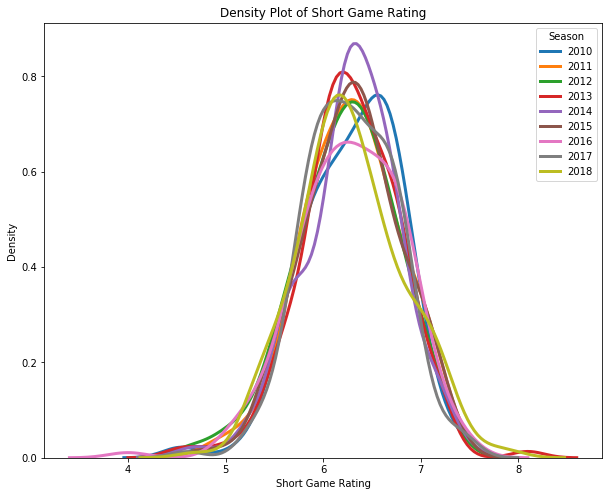

In [35]:
# DENSITY PLOT FOR SHORT GAME RATING

var_of_interest = "Short Game Rating - (RATING)"
season_lst = cln_all_pga_data_df["Season"].unique()

fig = plt.figure(figsize=(10,8))

for season in season_lst:
    short_gam_season = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==season, var_of_interest]
    
    sns.distplot(short_gam_season, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = season)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Season');
plt.title("Density Plot of Short Game Rating");
plt.xlabel("Short Game Rating");
plt.ylabel("Density");

## Analyze Proximity to Hole (ARG) - (AVG DTP) (IN)

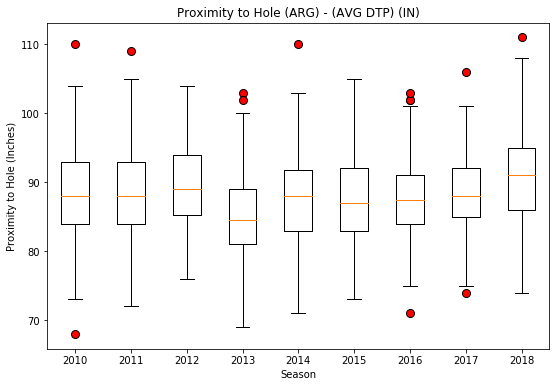

In [37]:
# BOXPLOT FOR PROXIMITY TO HOLE (ARG)

var_of_interest = "Proximity to Hole (ARG) - (AVG DTP) (IN)"

prox_hole_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,var_of_interest]
prox_hole_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,var_of_interest]
prox_hole_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,var_of_interest]
prox_hole_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,var_of_interest]
prox_hole_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,var_of_interest]
prox_hole_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,var_of_interest]
prox_hole_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,var_of_interest]
prox_hole_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,var_of_interest]
prox_hole_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,var_of_interest]

prox_hole_data_boxplot_to_plot = [prox_hole_2010, prox_hole_2011, prox_hole_2012,
                             prox_hole_2013, prox_hole_2014, prox_hole_2015,
                             prox_hole_2016, prox_hole_2017, prox_hole_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(prox_hole_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=8.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = var_of_interest,
       xlabel = "Season",
       ylabel = "Proximity to Hole (Inches)")
plt.show()

In [38]:
# PROXIMITY TO HOLE ONE-WAY ANOVA
# Our null hypothesis states that there are equal means in the populations from which the groups of data were sampled

print(st.f_oneway(prox_hole_2010, prox_hole_2011, prox_hole_2012,
                  prox_hole_2013, prox_hole_2014, prox_hole_2015,
                  prox_hole_2016, prox_hole_2017, prox_hole_2018))

print("P-value is < 0.05, therefore there are significant differences among the means")

F_onewayResult(statistic=10.917736367867201, pvalue=4.25226839441564e-15)
P-value is < 0.05, therefore there are significant differences among the means


In [39]:
m_comp = pairwise_tukeyhsd(endog=cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"], groups=cln_all_pga_data_df["Season"], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2010   2011   0.3892    0.9 -1.6145  2.3929  False
  2010   2012   1.3842 0.4336 -0.6033  3.3717  False
  2010   2013  -3.3583  0.001 -5.3791 -1.3376   True
  2010   2014  -0.8087    0.9 -2.8414  1.2241  False
  2010   2015  -0.6073    0.9 -2.6223  1.4076  False
  2010   2016  -0.3069    0.9 -2.3161  1.7024  False
  2010   2017   0.0721    0.9 -1.9288   2.073  False
  2010   2018   2.0667 0.0339  0.0817  4.0516   True
  2011   2012    0.995 0.8145 -1.0086  2.9987  False
  2011   2013  -3.7475  0.001 -5.7841 -1.7109   True
  2011   2014  -1.1978 0.6486 -3.2463  0.8506  False
  2011   2015  -0.9965 0.8256 -3.0274  1.0344  False
  2011   2016  -0.6961    0.9 -2.7213  1.3291  False
  2011   2017  -0.3171    0.9  -2.334  1.6999  False
  2011   2018   1.6775 0.1855 -0.3236  3.6786  False
  2012   2013  -4.7425  0.001 -6.7633 -2.7218 

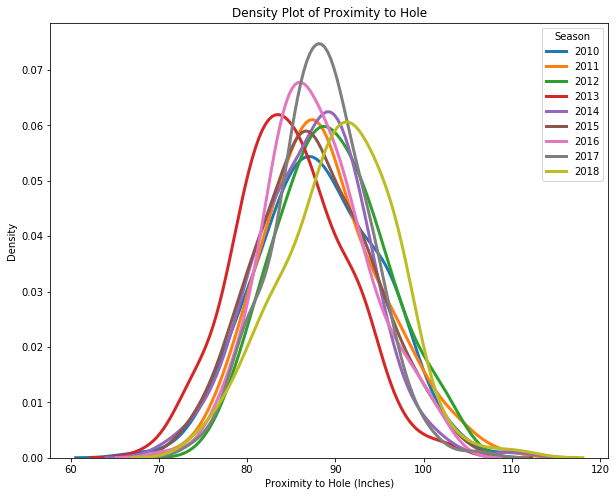

In [40]:
# DENSITY PLOT FOR PROXIMITY TO HOLE (ARG)

var_of_interest = "Proximity to Hole (ARG) - (AVG DTP) (IN)"
season_lst = cln_all_pga_data_df["Season"].unique()

fig = plt.figure(figsize=(10,8))

for season in season_lst:
    prox_hole_season = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==season, var_of_interest]
    
    sns.distplot(prox_hole_season, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = season)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Season');
plt.title("Density Plot of Proximity to Hole");
plt.xlabel("Proximity to Hole (Inches)");
plt.ylabel("Density");

## Analyze Putting Average

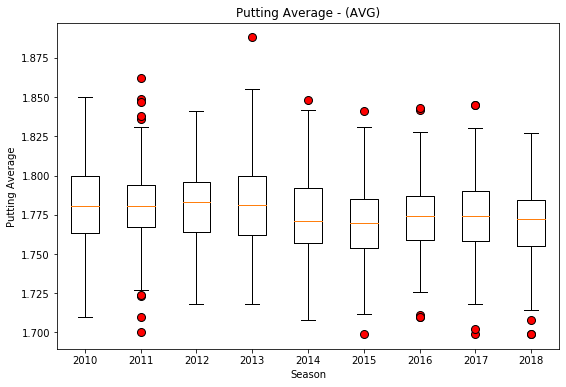

In [44]:
# BOXPLOT FOR PUTTING AVERAGE

var_of_interest = "Putting Average - (AVG)"

putt_avg_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,var_of_interest]
putt_avg_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,var_of_interest]
putt_avg_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,var_of_interest]
putt_avg_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,var_of_interest]
putt_avg_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,var_of_interest]
putt_avg_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,var_of_interest]
putt_avg_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,var_of_interest]
putt_avg_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,var_of_interest]
putt_avg_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,var_of_interest]

putt_avg_data_boxplot_to_plot = [putt_avg_2010, putt_avg_2011, putt_avg_2012,
                                 putt_avg_2013, putt_avg_2014, putt_avg_2015,
                                 putt_avg_2016, putt_avg_2017, putt_avg_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(putt_avg_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=8.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = var_of_interest,
       xlabel = "Season",
       ylabel = "Putting Average")
plt.show()

In [45]:
# PUTTING AVERAGE TO HOLE ONE-WAY ANOVA
# Our null hypothesis states that there are equal means in the populations from which the groups of data were sampled

print(st.f_oneway(putt_avg_2010, putt_avg_2011, putt_avg_2012,
                  putt_avg_2013, putt_avg_2014, putt_avg_2015,
                  putt_avg_2016, putt_avg_2017, putt_avg_2018))

print("P-value is < 0.05, therefore there are significant differences among the means")

F_onewayResult(statistic=6.991480783505422, pvalue=4.217974270632155e-09)
P-value is < 0.05, therefore there are significant differences among the means


In [46]:
m_comp = pairwise_tukeyhsd(endog=cln_all_pga_data_df["Putting Average - (AVG)"], groups=cln_all_pga_data_df["Season"], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2010   2011  -0.0025    0.9 -0.0105  0.0056  False
  2010   2012  -0.0029    0.9 -0.0109  0.0051  False
  2010   2013  -0.0014    0.9 -0.0095  0.0068  False
  2010   2014  -0.0064 0.2701 -0.0146  0.0018  False
  2010   2015  -0.0126  0.001 -0.0207 -0.0044   True
  2010   2016  -0.0095 0.0081 -0.0176 -0.0014   True
  2010   2017   -0.009 0.0168  -0.017 -0.0009   True
  2010   2018  -0.0129  0.001 -0.0209 -0.0049   True
  2011   2012  -0.0004    0.9 -0.0085  0.0077  False
  2011   2013   0.0011    0.9 -0.0071  0.0093  False
  2011   2014  -0.0039   0.85 -0.0122  0.0043  False
  2011   2015  -0.0101 0.0042 -0.0183 -0.0019   True
  2011   2016  -0.0071 0.1517 -0.0153  0.0011  False
  2011   2017  -0.0065  0.241 -0.0146  0.0016  False
  2011   2018  -0.0105  0.002 -0.0185 -0.0024   True
  2012   2013   0.0015    0.9 -0.0066  0.0097 

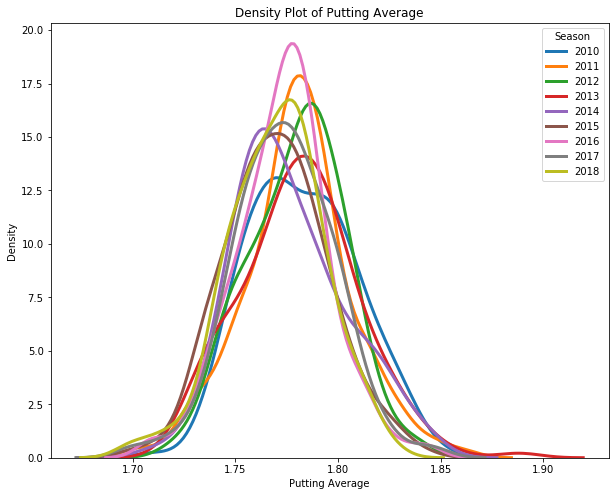

In [48]:
# DENSITY PLOT FOR PUTTING AVERAGE

var_of_interest = "Putting Average - (AVG)"
season_lst = cln_all_pga_data_df["Season"].unique()

fig = plt.figure(figsize=(10,8))

for season in season_lst:
    putt_avg_season = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==season, var_of_interest]
    
    sns.distplot(putt_avg_season, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = season)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Season');
plt.title("Density Plot of Putting Average");
plt.xlabel("Putting Average");
plt.ylabel("Density");

## Scatter Matrix - Look for any obvious correlations and trends

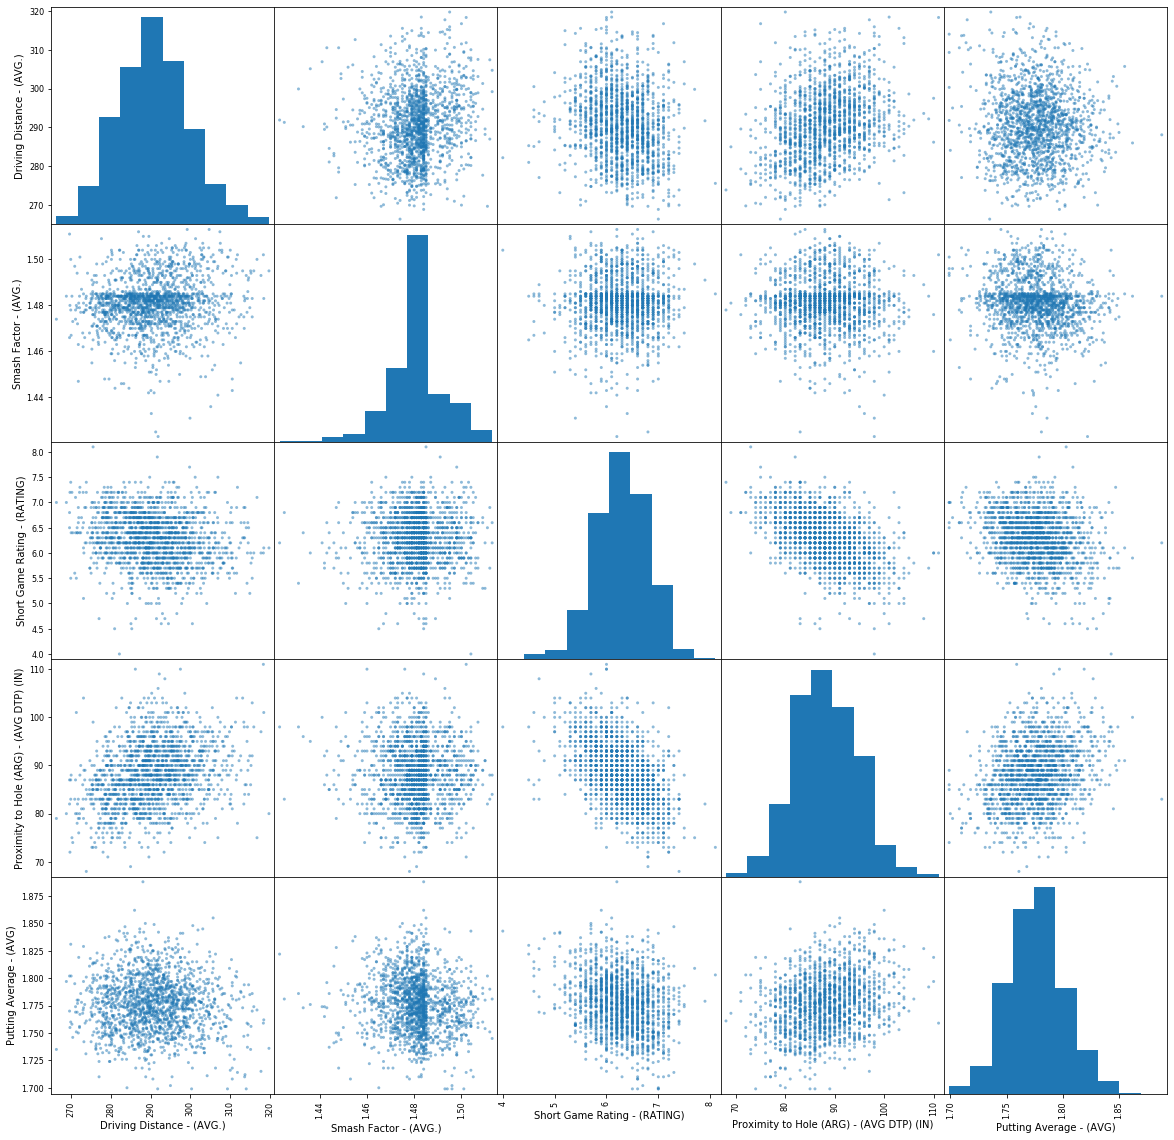

In [21]:
pd.plotting.scatter_matrix(cln_all_pga_data_df[["Driving Distance - (AVG.)",
                                                "Smash Factor - (AVG.)",
                                                "Short Game Rating - (RATING)",
                                                "Proximity to Hole (ARG) - (AVG DTP) (IN)",
                                                "Putting Average - (AVG)"]]
                                                , figsize = (20, 20));


In [22]:
corr_data_df = cln_all_pga_data_df.copy()
corr_data_df = corr_data_df[["Driving Distance - (AVG.)",
                             "Smash Factor - (AVG.)",
                             "Short Game Rating - (RATING)",
                             "Proximity to Hole (ARG) - (AVG DTP) (IN)",
                             "Putting Average - (AVG)"]]
corr_matrix = corr_data_df.corr().apply(lambda x: round(x, 3))
corr_matrix.style.background_gradient(cmap= 'viridis' , axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '12pt'})\
    .set_precision(2)


,Driving Distance - (AVG.),Smash Factor - (AVG.),Short Game Rating - (RATING),Proximity to Hole (ARG) - (AVG DTP) (IN),Putting Average - (AVG)
Driving Distance - (AVG.),1.00,0.12,-0.19,0.29,-0.05
Smash Factor - (AVG.),0.12,1.00,0.03,-0.03,-0.11
Short Game Rating - (RATING),-0.19,0.03,1.00,-0.51,-0.24
Proximity to Hole (ARG) - (AVG DTP) (IN),0.29,-0.03,-0.51,1.00,0.26
Putting Average - (AVG),-0.05,-0.11,-0.24,0.26,1.00


In [52]:
def statistic_ave_top_bottom_over_seasons(base_df, col_name, title ='', ylabel = '', format_prefix = '', format_set='{:,.0f}'):
    just_players_all=base_df.copy()
    just_players_all=just_players_all.drop_duplicates(subset="Player Name", keep="first") 
    player_season_groups=just_players_all.groupby(['Season'])
    
        # Divison by Seasons
    season_years_df = pd.DataFrame([2010,2011,2012,2013,2014,2015,2016,2017,2018])
    Full_Season_2010 = base_df.loc[base_df["Season"]==2010]
    Full_Season_2011 = base_df.loc[base_df["Season"]==2011]
    Full_Season_2012 = base_df.loc[base_df["Season"]==2012]
    Full_Season_2013 = base_df.loc[base_df["Season"]==2013]
    Full_Season_2014 = base_df.loc[base_df["Season"]==2014]
    Full_Season_2015 = base_df.loc[base_df["Season"]==2015]
    Full_Season_2016 = base_df.loc[base_df["Season"]==2016]
    Full_Season_2017 = base_df.loc[base_df["Season"]==2017]
    Full_Season_2018 = base_df.loc[base_df["Season"]==2018]

     # Top and Bottom 10 Players for each season by the statistic in the column name
    ave_by_season_all=player_season_groups[col_name].mean()
    ave_by_season_all_df = pd.DataFrame(ave_by_season_all)

    Full_Season_2010=Full_Season_2010.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2010 = Full_Season_2010.iloc[0:9]
    Full_Season_2010=Full_Season_2010.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2010 = Full_Season_2010.iloc[0:9]

    Full_Season_2011=Full_Season_2011.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2011 = Full_Season_2011.iloc[0:9]
    Full_Season_2011=Full_Season_2011.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2011 = Full_Season_2011.iloc[0:9]

    Full_Season_2012=Full_Season_2012.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2012 = Full_Season_2012.iloc[0:9]
    Full_Season_2012=Full_Season_2012.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2012 = Full_Season_2012.iloc[0:9]

    Full_Season_2013=Full_Season_2013.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2013 = Full_Season_2013.iloc[0:9]
    Full_Season_2013=Full_Season_2013.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2013 = Full_Season_2013.iloc[0:9]

    Full_Season_2014=Full_Season_2014.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2014 = Full_Season_2014.iloc[0:9]
    Full_Season_2014=Full_Season_2014.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2014 = Full_Season_2014.iloc[0:9]

    Full_Season_2015=Full_Season_2015.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2015 = Full_Season_2015.iloc[0:9]
    Full_Season_2015=Full_Season_2015.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2015 = Full_Season_2015.iloc[0:9]

    Full_Season_2016=Full_Season_2016.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2016 = Full_Season_2016.iloc[0:9]
    Full_Season_2016=Full_Season_2016.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2016 = Full_Season_2016.iloc[0:9]

    Full_Season_2017=Full_Season_2017.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2017 = Full_Season_2017.iloc[0:9]
    Full_Season_2017=Full_Season_2017.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2017 = Full_Season_2017.iloc[0:9]

    Full_Season_2018=Full_Season_2018.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2018 = Full_Season_2018.iloc[0:9]
    Full_Season_2018=Full_Season_2018.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2018 = Full_Season_2018.iloc[0:9]
    Top_10_by_season = pd.DataFrame([Top_10_Season_2010[col_name].mean(), 
                   Top_10_Season_2011[col_name].mean(), 
                   Top_10_Season_2012[col_name].mean(), 
                   Top_10_Season_2013[col_name].mean(), 
                   Top_10_Season_2014[col_name].mean(), 
                   Top_10_Season_2015[col_name].mean(), 
                   Top_10_Season_2016[col_name].mean(), 
                   Top_10_Season_2017[col_name].mean(), 
                   Top_10_Season_2018[col_name].mean()])

    Bottom_10_by_season = pd.DataFrame([Bottom_10_Season_2010[col_name].mean(), 
                   Bottom_10_Season_2011[col_name].mean(), 
                   Bottom_10_Season_2012[col_name].mean(), 
                   Bottom_10_Season_2013[col_name].mean(), 
                   Bottom_10_Season_2014[col_name].mean(), 
                   Bottom_10_Season_2015[col_name].mean(), 
                   Bottom_10_Season_2016[col_name].mean(), 
                   Bottom_10_Season_2017[col_name].mean(), 
                   Bottom_10_Season_2018[col_name].mean()])

    #Merging data frames for All Players, Top 10, and Bottom 10 
     #season_years_df is from above
    ave_by_season_all_df=ave_by_season_all_df.reset_index(drop=True)

    ave_line_graph=pd.merge(season_years_df, ave_by_season_all_df, right_index=True, left_index=True, suffixes=("A", "B"))
    ave_line_graph=pd.merge(ave_line_graph, Top_10_by_season, right_index=True, left_index=True, suffixes=("C", "D"))
    ave_line_graph=pd.merge(ave_line_graph, Bottom_10_by_season, right_index=True, left_index=True, suffixes=("E", "F"))

    # Rename Columns
    ave_line_graph.columns = ['Season', 'All Players', 'Top 10 Players', 'Bottom 10 Players']

    #Add index with years
    ave_line_graph.set_index('Season', inplace = True)


    ax= sns.lineplot(data=ave_line_graph, markers= True)
    ax.set(xlabel='Season', ylabel=ylabel, title=title)
    #changing ylables ticks
    y_value=[format_prefix + format_set.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(y_value)
    ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)


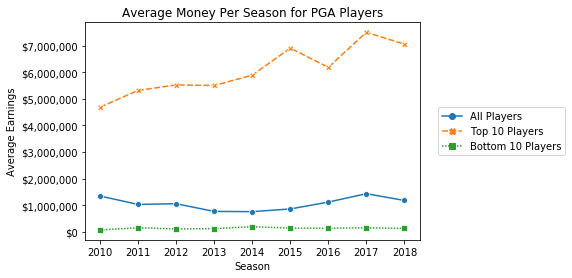

In [53]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)", ylabel='Average Earnings', title='Average Money Per Season for PGA Players', format_prefix = "$")

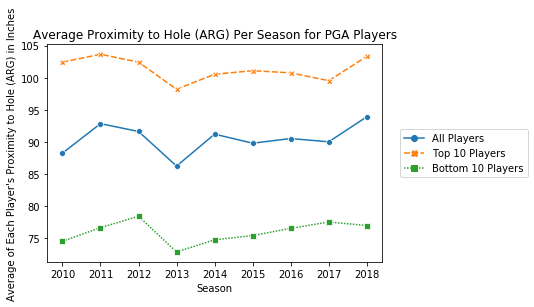

In [54]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Proximity to Hole (ARG) - (AVG DTP) (IN)", title='Average Proximity to Hole (ARG) Per Season for PGA Players', ylabel='''Average of Each Player's Proximity to Hole (ARG) in Inches''', format_prefix = "")

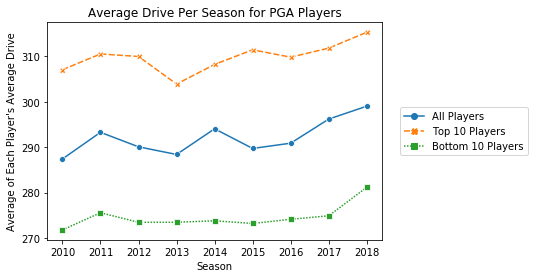

In [55]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Driving Distance - (AVG.)", ylabel='''Average of Each Player's Average Drive''', title='Average Drive Per Season for PGA Players', format_prefix = "")

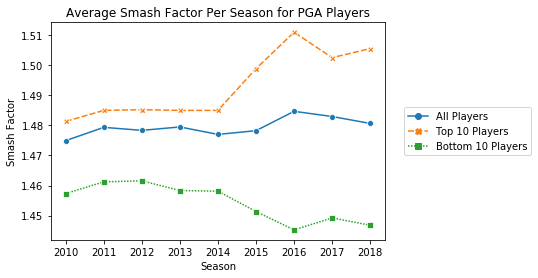

In [56]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Smash Factor - (AVG.)", ylabel='Smash Factor', title='Average Smash Factor Per Season for PGA Players', format_prefix = "", format_set='{:,.2f}')

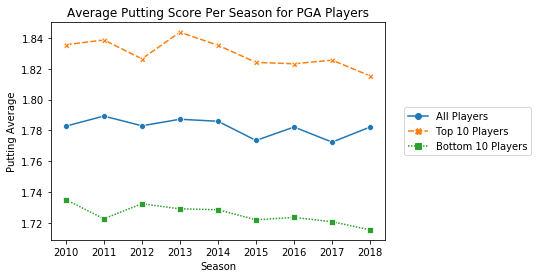

In [57]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Putting Average - (AVG)", ylabel='Putting Average', title='Average Putting Score Per Season for PGA Players', format_prefix = "", format_set='{:,.2f}')

In [58]:
#This method sets up the linear regression charts and saves a PNG of each
def linear_regression(base_df,col_x, col_y, title):
    
    just_players_all=base_df.copy()
    just_players_all=just_players_all.drop_duplicates(subset="Player Name", keep="first") 
    
    # This performs a linear regression on the two columns
    t_slope, t_intercept, t_r, t_p, t_std_err = linregress(just_players_all[col_x],just_players_all[col_y])

    # Create equation of line to calculate from linear regression
    t_fit = t_slope * just_players_all[col_x] + t_intercept

    #Makes scatterplot
    plt.scatter(just_players_all[col_x],just_players_all[col_y])
    
    #Makes Regression Line
    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.plot(just_players_all[col_x], t_fit, "--",color="red")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.show()
    
    #prints r-squared value
    print(f"The r-squared for the chart above is: {t_r*t_r}")

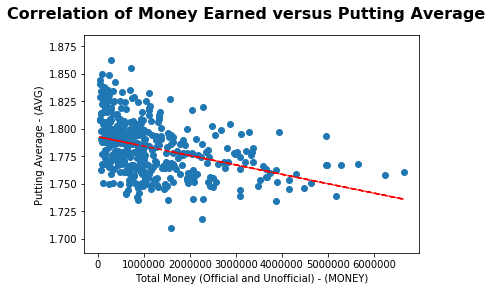

The r-squared for the chart above is: 0.15046247596388937


In [59]:
linear_regression(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)","Putting Average - (AVG)", "Correlation of Money Earned versus Putting Average")

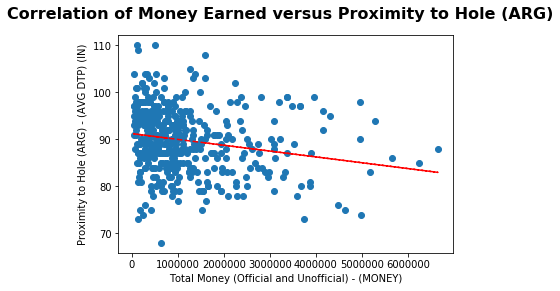

The r-squared for the chart above is: 0.04067547942634744


In [60]:
linear_regression(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)", "Proximity to Hole (ARG) - (AVG DTP) (IN)", "Correlation of Money Earned versus Proximity to Hole (ARG)")

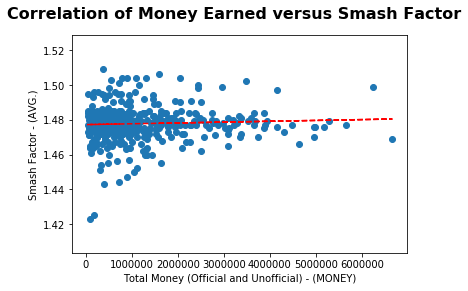

The r-squared for the chart above is: 0.0029008759764403546


In [61]:
linear_regression(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)", "Smash Factor - (AVG.)", "Correlation of Money Earned versus Smash Factor")

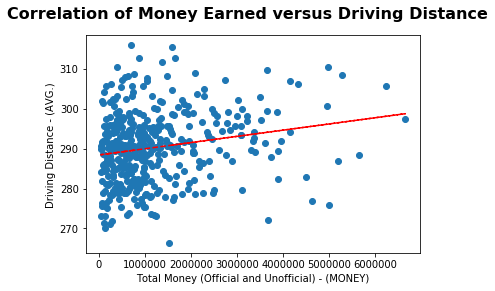

The r-squared for the chart above is: 0.03917407146608988


In [62]:
linear_regression(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)", "Driving Distance - (AVG.)", "Correlation of Money Earned versus Driving Distance")

## Examine 3 players who played all 9 seasons 2010-2018

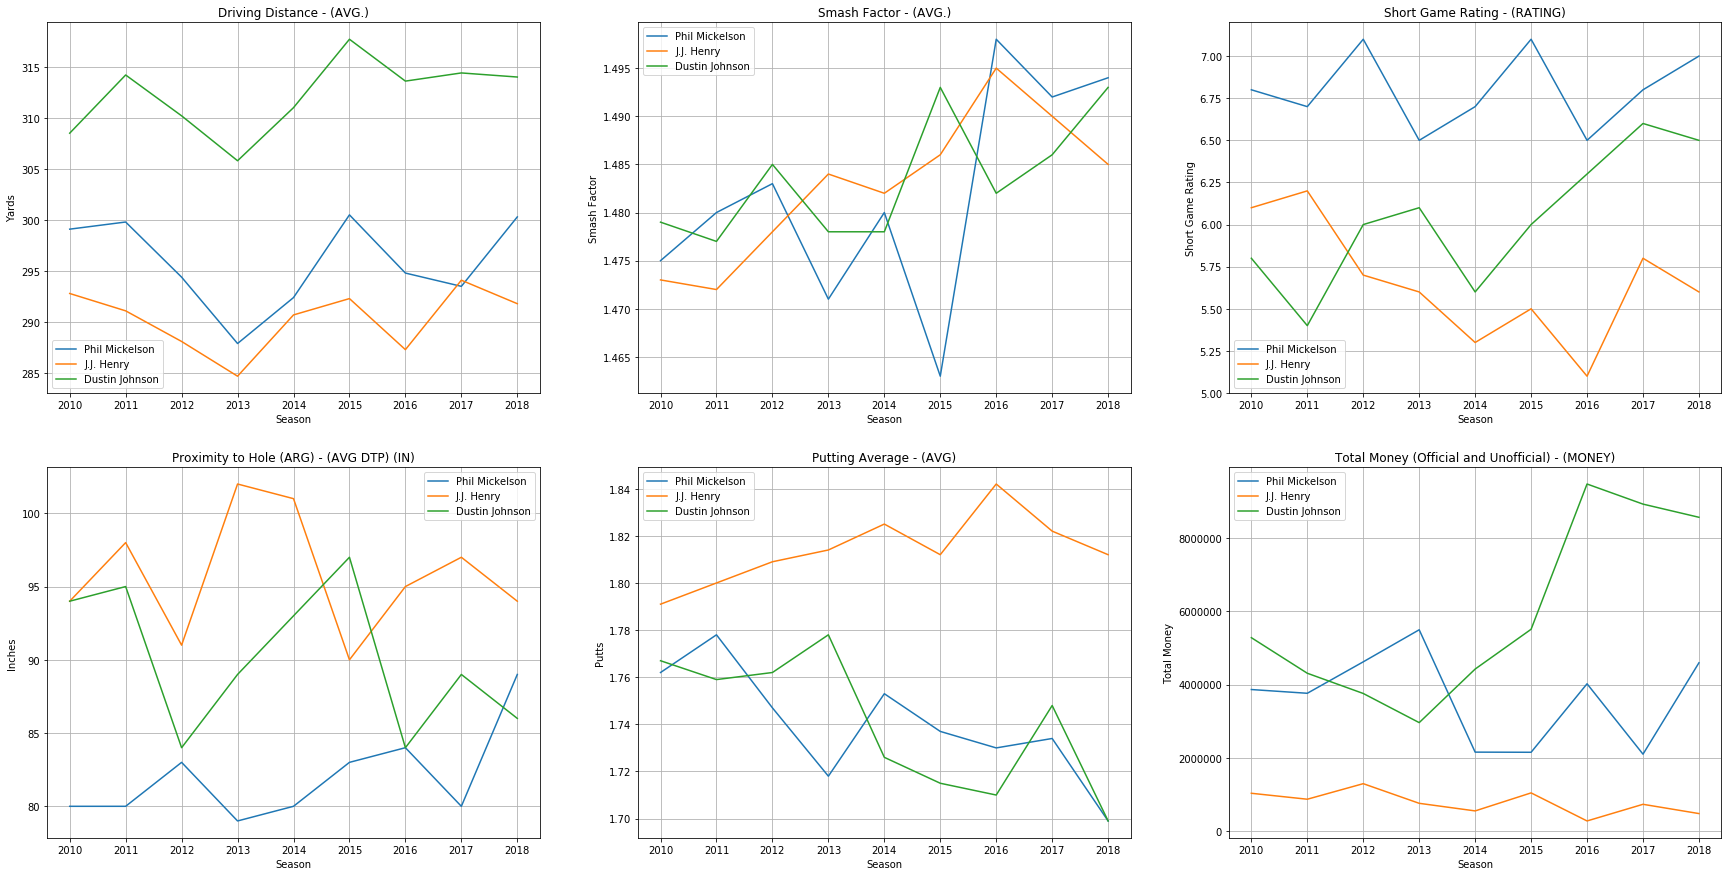

In [49]:
seasons = list(cln_all_pga_data_df["Season"].unique())
phil_data_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Player Name"] == "Phil Mickelson"]
jj_data_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Player Name"] == "J.J. Henry"]
dustin_data_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Player Name"] == "Dustin Johnson"]

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.plot(seasons, phil_data_df["Driving Distance - (AVG.)"], label="Phil Mickelson")
ax1.plot(seasons, jj_data_df["Driving Distance - (AVG.)"], label="J.J. Henry")
ax1.plot(seasons, dustin_data_df["Driving Distance - (AVG.)"], label="Dustin Johnson")
ax1.set(title = "Driving Distance - (AVG.)",
       xlabel = "Season",
       ylabel = "Yards")
ax1.legend(loc="best")
ax1.grid()

ax2.plot(seasons, phil_data_df["Smash Factor - (AVG.)"], label="Phil Mickelson")
ax2.plot(seasons, jj_data_df["Smash Factor - (AVG.)"], label="J.J. Henry")
ax2.plot(seasons, dustin_data_df["Smash Factor - (AVG.)"], label="Dustin Johnson")
ax2.set(title = "Smash Factor - (AVG.)",
       xlabel = "Season",
       ylabel = "Smash Factor")
ax2.legend(loc="best")
ax2.grid()

ax3.plot(seasons, phil_data_df["Short Game Rating - (RATING)"], label="Phil Mickelson")
ax3.plot(seasons, jj_data_df["Short Game Rating - (RATING)"], label="J.J. Henry")
ax3.plot(seasons, dustin_data_df["Short Game Rating - (RATING)"], label="Dustin Johnson")
ax3.set(title = "Short Game Rating - (RATING)",
       xlabel = "Season",
       ylabel = "Short Game Rating")
ax3.legend(loc="best")
ax3.grid()

ax4.plot(seasons, phil_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"], label="Phil Mickelson")
ax4.plot(seasons, jj_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"], label="J.J. Henry")
ax4.plot(seasons, dustin_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"], label="Dustin Johnson")
ax4.set(title = "Proximity to Hole (ARG) - (AVG DTP) (IN)",
       xlabel = "Season",
       ylabel = "Inches")
ax4.legend(loc="best")
ax4.grid()

ax5.plot(seasons, phil_data_df["Putting Average - (AVG)"], label="Phil Mickelson")
ax5.plot(seasons, jj_data_df["Putting Average - (AVG)"], label="J.J. Henry")
ax5.plot(seasons, dustin_data_df["Putting Average - (AVG)"], label="Dustin Johnson")
ax5.set(title = "Putting Average - (AVG)",
       xlabel = "Season",
       ylabel = "Putts")
ax5.legend(loc="best")
ax5.grid()

ax6.plot(seasons, phil_data_df["Total Money (Official and Unofficial) - (MONEY)"], label="Phil Mickelson")
ax6.plot(seasons, jj_data_df["Total Money (Official and Unofficial) - (MONEY)"], label="J.J. Henry")
ax6.plot(seasons, dustin_data_df["Total Money (Official and Unofficial) - (MONEY)"], label="Dustin Johnson")
ax6.set(title = "Total Money (Official and Unofficial) - (MONEY)",
       xlabel = "Season",
       ylabel = "Total Money")
ax6.legend(loc="best")
ax6.grid()

plt.show()